In [10]:
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
df=pd.read_csv("data/Pokemon.csv")
df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


## ***Verify target column balance***

In [12]:
counts = df['Legendary'].value_counts()
counts

Legendary
False    735
True      65
Name: count, dtype: int64

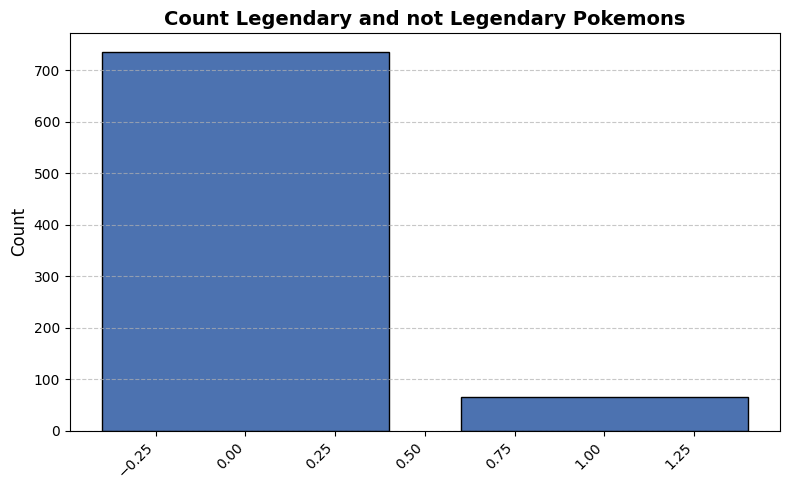

In [13]:

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color='#4C72B0', edgecolor='black')

plt.ylabel('Count', fontsize=12)
plt.title('Count Legendary and not Legendary Pokemons', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### ***When data is so unbalanced training will give better results than it actually is.***
### ***Make sure you balance data especially when you predict something more important:have disease or not,fraud or not fraud***


In [ ]:
#Drop unusefull column
df = df.drop(columns=["#"],inplace=True)

### ***Undersampling-simply reduce samples in the majority class so that it matches the minority class***

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


target_column = "Legendary"

X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority only in train data
majority_class = train_data[train_data[target_column] == 0]
minority_class = train_data[train_data[target_column] == 1]

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

# Shuffle the new balanced training set
train_balanced = pd.concat([majority_downsampled, minority_class])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [16]:
from sklearn.preprocessing import LabelEncoder
def encode_object_columns(df_input):
    """
    Encodes object and boolean columns in a DataFrame using LabelEncoder.
    """
    df_encoded = df_input.copy()
    obj_cols = df_encoded.select_dtypes(include=["object", "boolean"]).columns
    for col in obj_cols:
        le = LabelEncoder()
        df_encoded[col] = df_encoded[col].astype(str)
        df_encoded[col] = le.fit_transform(df_encoded[col])
    return df_encoded

train_balanced = encode_object_columns(train_balanced)


In [17]:
X_train_balanced = train_balanced.drop(columns=[target_column])
y_train_balanced = train_balanced[target_column]

print(y_train_balanced.value_counts())


Legendary
0    52
1    52
Name: count, dtype: int64


### ***Class Weight - give more importance to the minority class during training without changing your data.***

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
import numpy as np
import seaborn as sns



classes = np.unique(y_train_balanced)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_balanced
)
class_weights = dict(zip(classes, weights))
print(class_weights)

model = RandomForestClassifier(
    class_weight=class_weights,
    random_state=42
)
model.fit(X_train_balanced, y_train_balanced)




{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
def evaluate_model(model, X_test, y_test, average='binary'):
    y_pred = model.predict(X_test)
    try:
        y_probs = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_probs)
    except AttributeError:
        roc_auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    rec = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    if roc_auc is not None:
        print(f'ROC AUC: {roc_auc:.4f}')

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Accuracy: 0.9375
Precision: 0.5556
Recall: 1.0000
F1 Score: 0.7143
ROC AUC: 0.9780

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       118
           1       0.56      1.00      0.71        10

    accuracy                           0.94       128
   macro avg       0.78      0.97      0.84       128
weighted avg       0.97      0.94      0.95       128



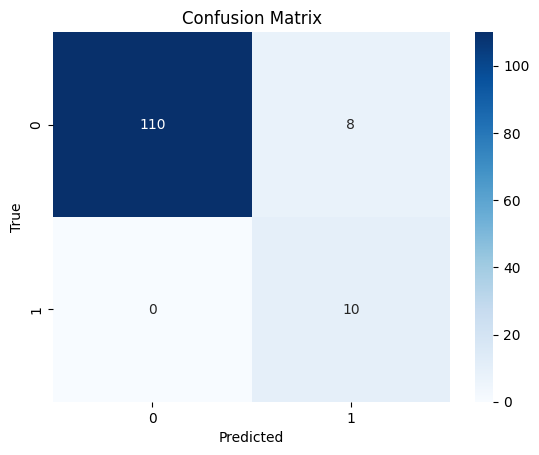

In [ ]:
evaluate_model(model, X_test, y_test, average='binary')

#### ***As I said earlier accuracy is very high but Precision, Recall, and F1 Score are moderate (0.70) — this shows the model finds the minority class but not perfectly.***

## ***Oversampling - generate new candidates for minority class***

### **SMOTE** - Creates synthetic samples for the minority class by interpolating between existing samples.



Accuracy: 0.9375
Precision: 0.6000
Recall: 0.6923
F1 Score: 0.6429
ROC AUC: 0.9765

Classification Report:
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       147
        True       0.60      0.69      0.64        13

    accuracy                           0.94       160
   macro avg       0.79      0.83      0.80       160
weighted avg       0.94      0.94      0.94       160



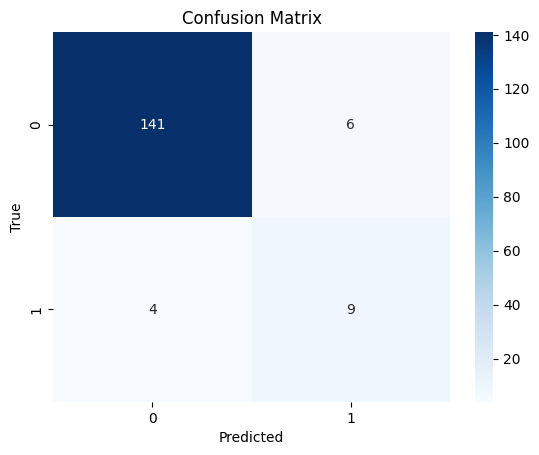

In [28]:
from crucio import SMOTE


train_df = X_train.copy()

train_df[target_column] = y_train

smote = SMOTE()
smote_balanced_df = smote.balance(df=train_df, target=target_column)

X_train_smote = smote_balanced_df.drop(columns=[target_column])
y_train_smote = smote_balanced_df[target_column]

model.fit(X_train_smote, y_train_smote)

evaluate_model(model, X_test=X_test, y_test=y_test)


## **SMOTEENN** - (SMOTE) + (ENN)
### ENN = If sample’s label differs from the majority label of its k nearest neighbor it is removed

Accuracy: 0.9500
Precision: 0.6471
Recall: 0.8462
F1 Score: 0.7333
ROC AUC: 0.9770

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.96      0.97       147
        True       0.65      0.85      0.73        13

    accuracy                           0.95       160
   macro avg       0.82      0.90      0.85       160
weighted avg       0.96      0.95      0.95       160



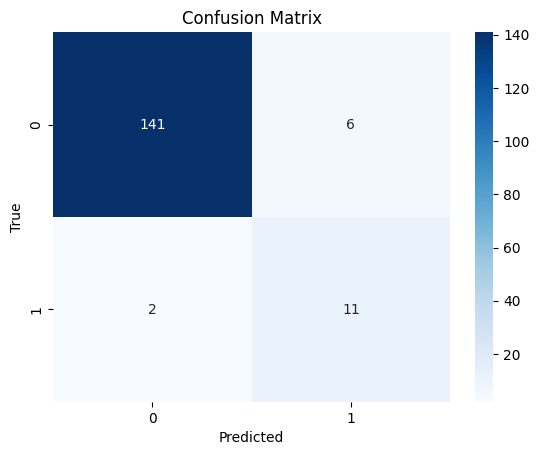

In [ ]:
from crucio import SMOTEENN

smoteenn = SMOTEENN()

smoteenn_balanced_df = smoteenn.balance(df=train_df, target=target_column)

X_train_smoteenn = smoteenn_balanced_df.drop(columns=[target_column])
y_train_smoteenn = smoteenn_balanced_df[target_column]

model.fit(X_train_smoteenn, y_train_smoteenn)

evaluate_model(model, X_test=X_test, y_test=y_test)

### ***TKRKNN - Instead of adding anything, it removes majority class samples that are less important it keeps only those majority samples that are close to or influencing minority samples (based on how often majority points appear in minority samples’ neighbors).***

Accuracy: 0.9437
Precision: 0.8333
Recall: 0.3846
F1 Score: 0.5263
ROC AUC: 0.9856

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97       147
        True       0.83      0.38      0.53        13

    accuracy                           0.94       160
   macro avg       0.89      0.69      0.75       160
weighted avg       0.94      0.94      0.93       160



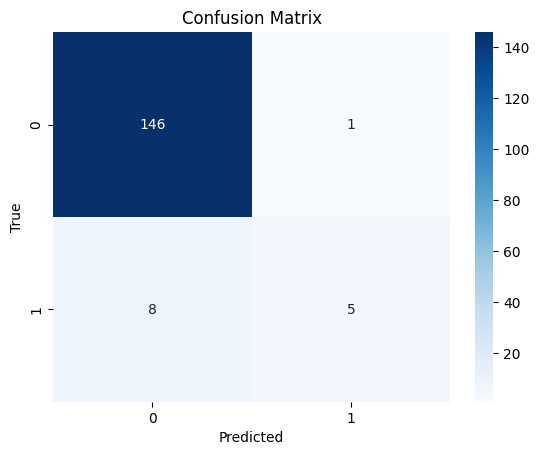

In [32]:
from crucio import TKRKNN

tkrknn = TKRKNN()

tkrknn_balanced_df = tkrknn.balance(df=train_df, target=target_column)

X_train_tkrknn = tkrknn_balanced_df.drop(columns=[target_column])
y_train_tkrknn = tkrknn_balanced_df[target_column]

model.fit(X_train_tkrknn, y_train_tkrknn)

evaluate_model(model, X_test=X_test, y_test=y_test)



## **Other most used techniques for balancing**

| Technique               | Use When                         | Pros                         | Cons                       |
| ----------------------- | -------------------------------- | ---------------------------- | -------------------------- |
| SMOTE & Variants        | Tabular data, moderate imbalance | Effective, easy to implement | Can create noisy samples   |
| ADASYN                  | Complex minority class           | Focus on hard examples       | Can overfit in some cases  |
| Random Sampling         | Baseline/simple cases            | Simple & fast                | Risk of over/underfitting  |
| Tomek Links / ENN       | Clean data post-oversampling     | Removes noise & overlaps     | Might remove useful points |
| Ensemble Methods        | Complex, high-dimensional data   | Robust, strong performance   | Computationally expensive  |
| Cost-Sensitive Learning | When data changes not allowed    | No data modification         | Requires careful tuning    |


# Common Python Libraries for Imbalanced Class
```python
1. from imblearn.over_sampling import SMOTE, SMOTEENN, SMOTETomek
2. from imblearn.over_sampling import ADASYN
3. from imblearn.over_sampling import RandomOverSampler
   from imblearn.under_sampling import RandomUnderSampler
4. from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
5. from imblearn.under_sampling import ClusterCentroids
6. from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalanceCascade
